In [4]:
!pip install rasterio numpy matplotlib tensorflow albumentations scikit-learn opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.9 MB/s eta 0:00:00:00:0100:01


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
from tqdm import tqdm
import rasterio

In [6]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define paths
DATA_DIR = '/kaggle/input/satellite-segmentation-data-handeled/data handeld the _/data'
IMAGE_DIR = os.path.join(DATA_DIR, 'images')
MASK_DIR = os.path.join(DATA_DIR, 'labels')


Generating single image visualizations...


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


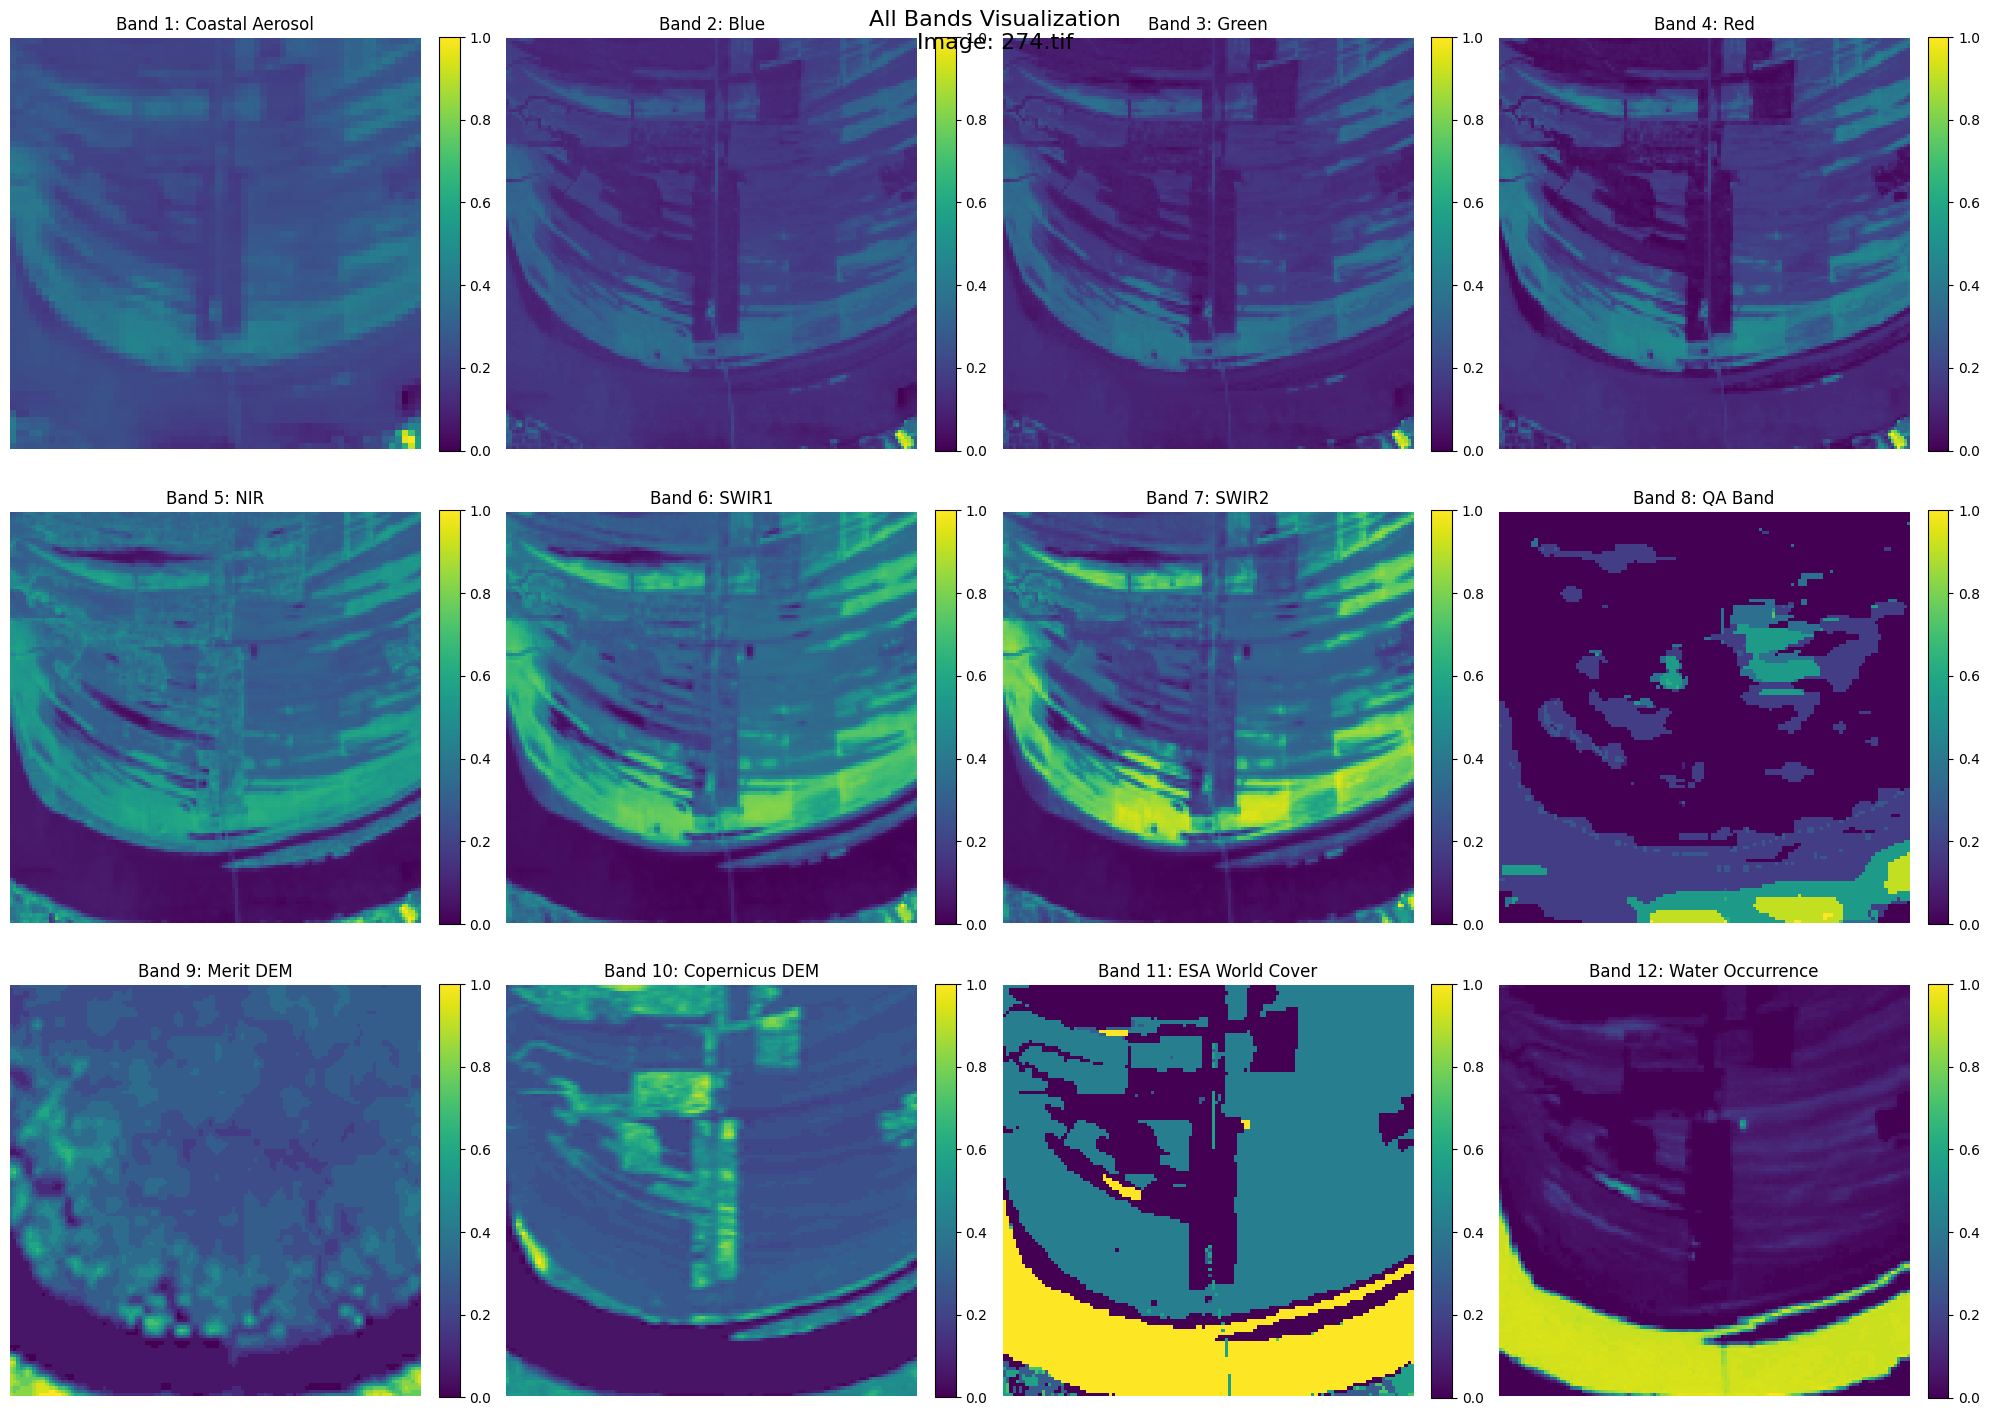


Band Statistics:

Band: Coastal Aerosol
min: -375.0000
max: 3184.0000
mean: 545.3777
std: 261.0050
median: 486.0000

Band: Blue
min: -137.0000
max: 4148.0000
mean: 638.6865
std: 331.3442
median: 566.0000

Band: Green
min: 311.0000
max: 4789.0000
mean: 1037.3189
std: 424.2736
median: 918.0000

Band: Red
min: 279.0000
max: 5239.0000
mean: 1163.3834
std: 601.0647
median: 1031.0000

Band: NIR
min: 133.0000
max: 5747.0000
mean: 1911.7664
std: 908.5906
median: 1997.0000

Band: SWIR1
min: 46.0000
max: 6073.0000
mean: 2045.4766
std: 1260.9442
median: 2050.0000

Band: SWIR2
min: 30.0000
max: 4811.0000
mean: 1588.7393
std: 1162.5904
median: 1422.0000

Band: QA Band
min: 64.0000
max: 240.0000
mean: 83.3926
std: 33.7795
median: 64.0000

Band: Merit DEM
min: 110.0000
max: 127.0000
mean: 114.4790
std: 2.1424
median: 115.0000

Band: Copernicus DEM
min: 104.0000
max: 141.0000
mean: 114.4918
std: 6.0426
median: 114.0000

Band: ESA World Cover
min: 10.0000
max: 80.0000
mean: 39.5319
std: 23.6329
median

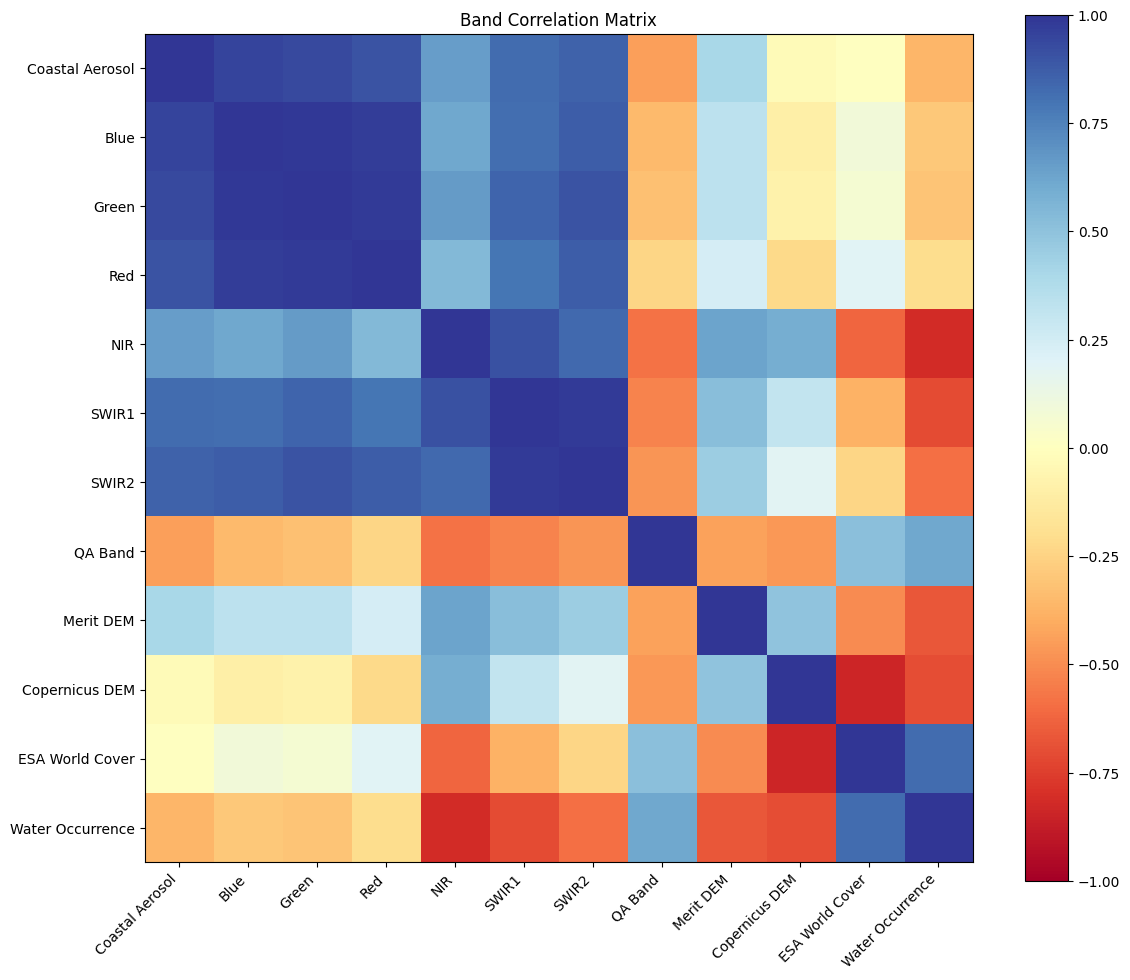


Generating RGB combinations...


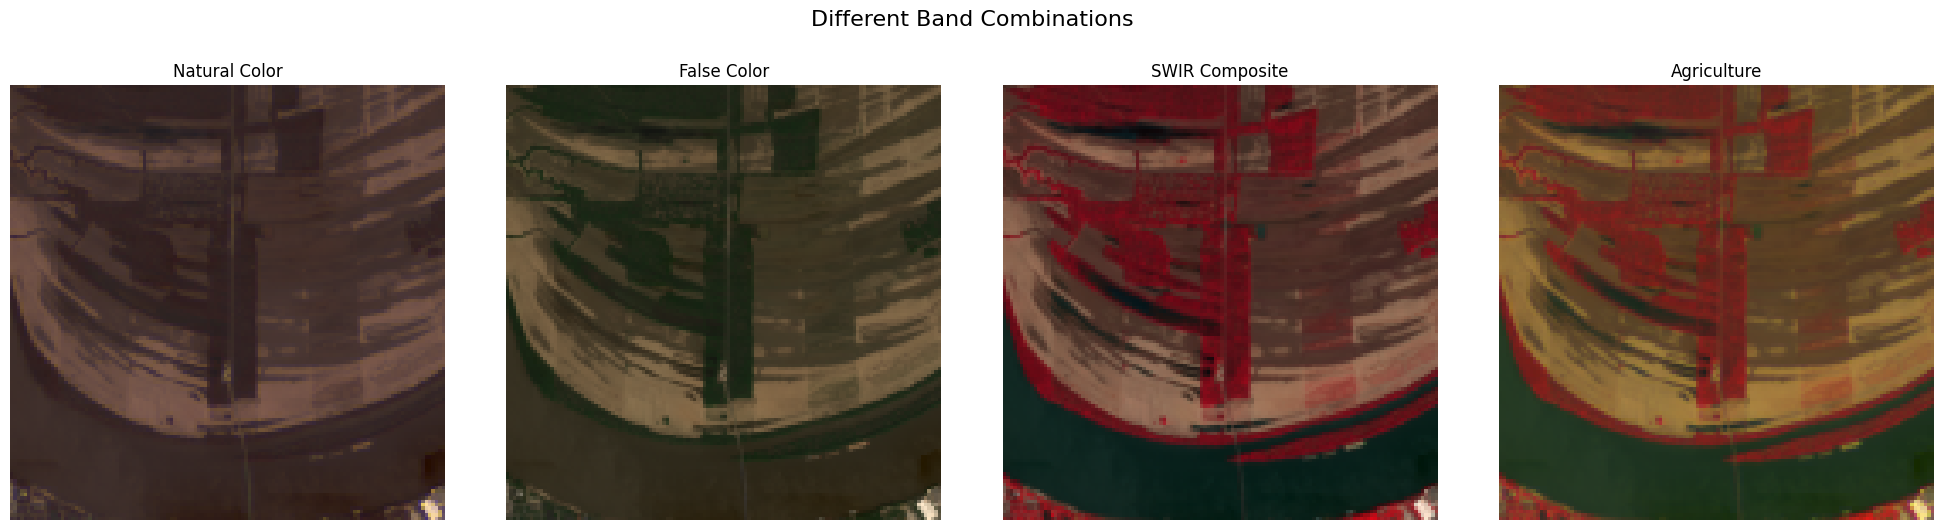

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
from tqdm import tqdm

# Define band names
BAND_NAMES = [
    'Coastal Aerosol',
    'Blue',
    'Green',
    'Red',
    'NIR',
    'SWIR1',
    'SWIR2',
    'QA Band',
    'Merit DEM',
    'Copernicus DEM',
    'ESA World Cover',
    'Water Occurrence'
]

def visualize_all_bands(image_path, save_path=None):
    """
    Visualize all 12 bands of a single image
    Args:
        image_path: Path to the TIF image
        save_path: Optional path to save the visualization
    """
    # Read the image
    with rasterio.open(image_path) as src:
        image = src.read()
        
    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # Calculate number of rows and columns for subplot grid
    n_rows = 3
    n_cols = 4
    
    # Plot each band
    for i in range(12):
        ax = plt.subplot(n_rows, n_cols, i+1)
        
        # Normalize the band for visualization
        band = image[i]
        band_normalized = (band - band.min()) / (band.max() - band.min())
        
        # Plot the band
        im = plt.imshow(band_normalized, cmap='viridis')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.title(f'Band {i+1}: {BAND_NAMES[i]}')
        plt.axis('off')
    
    plt.suptitle(f'All Bands Visualization\nImage: {os.path.basename(image_path)}', 
                 fontsize=16, y=0.95)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()

def create_band_statistics(image_path):
    """
    Create statistics for each band
    Args:
        image_path: Path to the TIF image
    Returns:
        Dictionary containing statistics for each band
    """
    with rasterio.open(image_path) as src:
        image = src.read()
    
    stats = {}
    for i in range(12):
        band = image[i]
        stats[BAND_NAMES[i]] = {
            'min': band.min(),
            'max': band.max(),
            'mean': band.mean(),
            'std': band.std(),
            'median': np.median(band)
        }
    return stats

def plot_band_correlations(image_path):
    """
    Plot correlation matrix between bands
    Args:
        image_path: Path to the TIF image
    """
    with rasterio.open(image_path) as src:
        image = src.read()
    
    # Reshape bands for correlation calculation
    bands_reshaped = [band.flatten() for band in image]
    correlation_matrix = np.corrcoef(bands_reshaped)
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    im = plt.imshow(correlation_matrix, cmap='RdYlBu', vmin=-1, vmax=1)
    plt.colorbar(im)
    
    # Add band names to axes
    plt.xticks(range(12), BAND_NAMES, rotation=45, ha='right')
    plt.yticks(range(12), BAND_NAMES)
    
    plt.title('Band Correlation Matrix')
    plt.tight_layout()
    plt.show()

def visualize_rgb_combinations(image_path):
    """
    Visualize different RGB band combinations
    Args:
        image_path: Path to the TIF image
    """
    with rasterio.open(image_path) as src:
        image = src.read()
    
    # Define different band combinations
    combinations = {
        'Natural Color': (3, 2, 1),  # Red, Green, Blue
        'False Color': (4, 3, 2),    # NIR, Red, Green
        'SWIR Composite': (5, 4, 3), # SWIR1, NIR, Red
        'Agriculture': (5, 4, 1)     # SWIR1, NIR, Coastal
    }
    
    plt.figure(figsize=(20, 5))
    
    for i, (name, bands) in enumerate(combinations.items(), 1):
        plt.subplot(1, 4, i)
        
        # Create RGB composite
        rgb = np.dstack([image[b-1] for b in bands])
        
        # Normalize
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
        
        plt.imshow(rgb)
        plt.title(name)
        plt.axis('off')
    
    plt.suptitle('Different Band Combinations', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

# Function to process multiple images
def process_all_images(image_dir, output_dir):
    """
    Process all images in a directory
    Args:
        image_dir: Directory containing TIF images
        output_dir: Directory to save visualizations
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all TIF files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    # Process each image
    for image_file in tqdm(image_files, desc="Processing images"):
        image_path = os.path.join(image_dir, image_file)
        
        # Create output paths
        base_name = os.path.splitext(image_file)[0]
        bands_output = os.path.join(output_dir, f"{base_name}_bands.png")
        
        # Generate visualizations
        visualize_all_bands(image_path, bands_output)
        
        # Save statistics
        stats = create_band_statistics(image_path)
        stats_output = os.path.join(output_dir, f"{base_name}_stats.txt")
        with open(stats_output, 'w') as f:
            for band, band_stats in stats.items():
                f.write(f"\nBand: {band}\n")
                for stat_name, value in band_stats.items():
                    f.write(f"{stat_name}: {value:.4f}\n")

# Example usage:
IMAGE_DIR = IMAGE_DIR
#OUTPUT_DIR = './visualizations'

# Create visualizations for a single image
sample_image_path = os.path.join(IMAGE_DIR, os.listdir(IMAGE_DIR)[0])

print("Generating single image visualizations...")
# Basic band visualization
visualize_all_bands(sample_image_path)

# Band statistics
stats = create_band_statistics(sample_image_path)
print("\nBand Statistics:")
for band, band_stats in stats.items():
    print(f"\nBand: {band}")
    for stat_name, value in band_stats.items():
        print(f"{stat_name}: {value:.4f}")

# Correlation matrix
print("\nGenerating correlation matrix...")
plot_band_correlations(sample_image_path)

# RGB combinations
print("\nGenerating RGB combinations...")
visualize_rgb_combinations(sample_image_path)

# Process all images
# print("\nProcessing all images...")
# process_all_images(IMAGE_DIR, OUTPUT_DIR)

# print("Visualization complete! Check the output directory for results.")

In [8]:
# Function to load and preprocess TIF images
def load_tif_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        # Select three bands (you can modify these indices based on your needs)
        image = image[[4, 5, 11], :, :]  # Using bands 4,5,11 as nir, swir1 and Water Occurrence
        image = np.transpose(image, (1, 2, 0))
        image = cv2.resize(image, (128, 128))
        # Normalize
        image = image.astype(np.float32)
        image = (image - image.min()) / (image.max() - image.min())
    return image

# Function to load and preprocess masks
def load_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128))
    mask = (mask > 0).astype(np.float32)
    return mask[..., np.newaxis]

# Load the data
print("Loading data...")
image_files = sorted([os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR) if f.endswith('.tif')])
mask_files = sorted([os.path.join(MASK_DIR, f) for f in os.listdir(MASK_DIR) if f.endswith('.png')])

images = []
masks = []

for img_path, mask_path in tqdm(zip(image_files, mask_files)):
    img = load_tif_image(img_path)
    mask = load_mask(mask_path)
    images.append(img)
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")

# Split the data
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Loading data...


306it [00:10, 28.73it/s]


Images shape: (306, 128, 128, 3)
Masks shape: (306, 128, 128, 1)


Performing EDA...
Number of images: 306
Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)


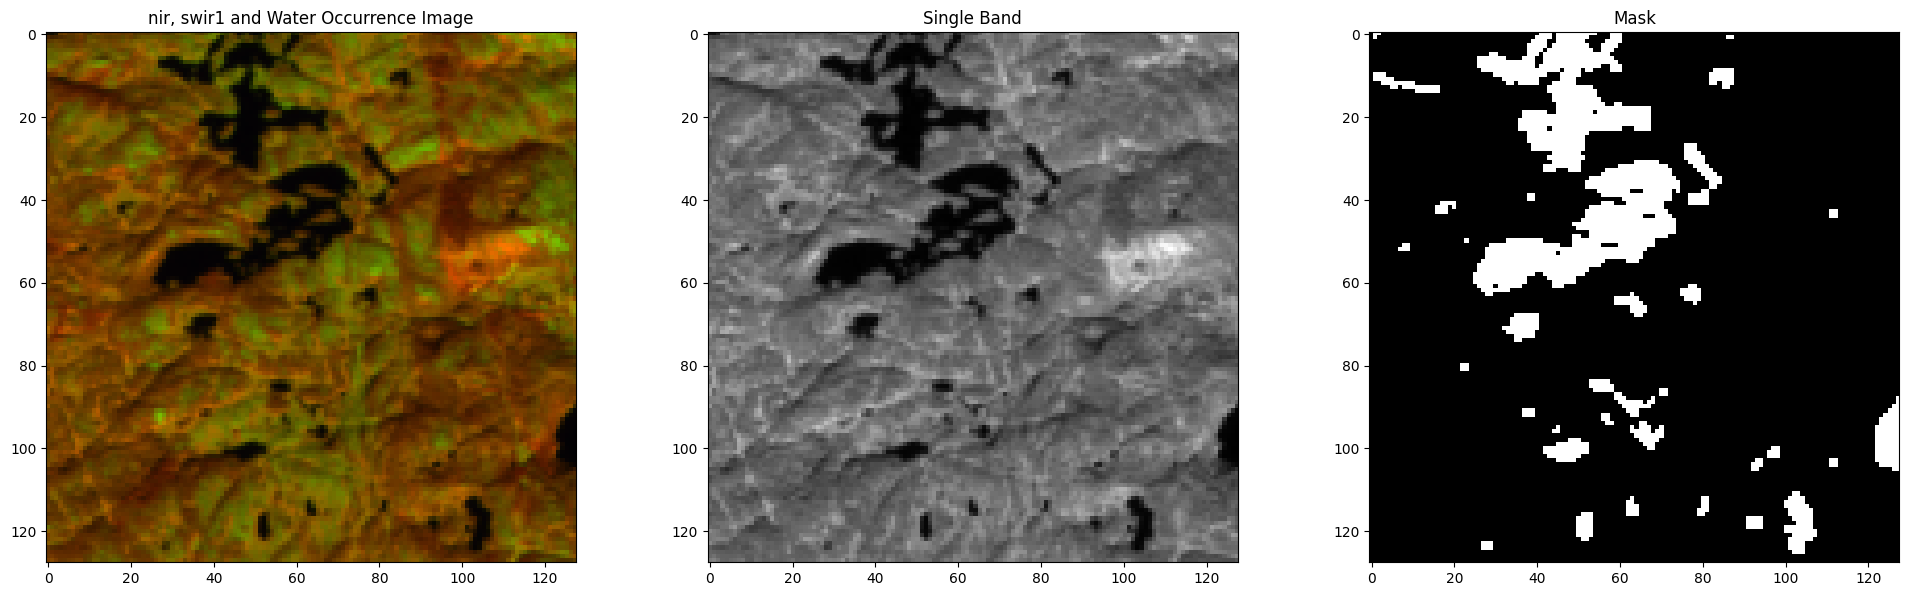

Training samples: 214
Validation samples: 46
Test samples: 46


In [18]:
# EDA and Visualization
print("Performing EDA...")
# Print basic information
print(f"Number of images: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Mask shape: {masks[0].shape}")

# Visualize sample image and mask
plt.figure(figsize=(20, 6))

# Plot RGB image - corrected for proper display
plt.subplot(131)
plt.title("nir, swir1 and Water Occurrence Image")

# If images are already in (H, W, C) format (128, 128, 3)
rgb_img = images[0]  # No need for transpose if already in correct format

# Normalize values for better visualization
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

plt.imshow(rgb_img)

# Plot single band
plt.subplot(132)
plt.title("Single Band")
plt.imshow(images[0][:,:,0], cmap='gray')  # Using first channel of RGB image

# Plot mask
plt.subplot(133)
plt.title("Mask")
# If mask is (128, 128, 1), we need to squeeze it to (128, 128)
plt.imshow(masks[0].squeeze(), cmap='gray')

plt.tight_layout()
plt.show()

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

In [10]:
# Define metrics and loss functions
def dice_coefficient(y_true, y_pred):
    smooth = 1e-15
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice

In [11]:

# Create the model
def create_improved_model(input_shape):
    # Use EfficientNetB3 instead of B0 for better feature extraction
    base_model = tf.keras.applications.EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Get encoder features
    s1 = base_model.get_layer('block2a_expand_activation').output
    s2 = base_model.get_layer('block3a_expand_activation').output
    s3 = base_model.get_layer('block4a_expand_activation').output
    s4 = base_model.get_layer('block6a_expand_activation').output
    
    # Bridge
    b1 = base_model.output
    
    # Improved decoder with attention mechanism
    def attention_block(x, skip):
        filters = x.shape[-1]
        g1 = Conv2D(filters, 1)(skip)
        g1 = BatchNormalization()(g1)
        x1 = Conv2D(filters, 1)(x)
        x1 = BatchNormalization()(x1)
        psi = Activation('relu')(add([g1, x1]))
        psi = Conv2D(1, 1)(psi)
        psi = BatchNormalization()(psi)
        psi = Activation('sigmoid')(psi)
        return multiply([skip, psi])

    # Decoder with attention and residual connections
    def decoder_block(x, skip, filters):
        x = UpSampling2D((2, 2))(x)
        attention = attention_block(x, skip)
        x = Concatenate()([x, attention])
        
        # Main path
        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.25)(x)
        
        # Residual path
        residual = Conv2D(filters, 1, padding='same')(x)
        residual = BatchNormalization()(residual)
        
        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.25)(x)
        
        x = add([x, residual])
        return x

    # Decoder path
    x = decoder_block(b1, s4, 320)
    x = decoder_block(x, s3, 160)
    x = decoder_block(x, s2, 80)
    x = decoder_block(x, s1, 40)
    
    # Final upsampling
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    # Output with squeeze-excitation
    x = Conv2D(16, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Squeeze-Excitation block
    se = GlobalAveragePooling2D()(x)
    se = Dense(16 // 4, activation='relu')(se)
    se = Dense(16, activation='sigmoid')(se)
    se = Reshape((1, 1, 16))(se)
    x = multiply([x, se])
    
    outputs = Conv2D(1, 1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Improved loss function
def focal_tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, gamma=4/3):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    
    tversky = (tp + 1e-7) / (tp + alpha*fp + beta*fn + 1e-7)
    return tf.pow((1 - tversky), gamma)

# Create and compile model with improved settings
model = create_improved_model(input_shape=(128, 128, 3))

# Custom learning rate schedule
initial_learning_rate = 1e-3
decay_steps = 1000
decay_rate = 0.9

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate,
    staircase=True
)





43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
class SegmentationDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=16, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        
        # Calculate sample weights
        self.sample_weights = self.calculate_sample_weights()
        
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def calculate_sample_weights(self):
        weights = np.zeros(len(self.y))
        for i in range(len(self.y)):
            n_negative = np.sum(self.y[i] == 0)
            n_positive = np.sum(self.y[i] == 1)
            total = n_negative + n_positive
            
            if n_positive > 0:
                weight = (total / (2 * n_positive))
            else:
                weight = 1.0
                
            weights[i] = weight
        return weights

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = self.X[batch_indexes]
        batch_y = self.y[batch_indexes]
        batch_weights = self.sample_weights[batch_indexes]
        
        return batch_X, batch_y, batch_weights

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Create generators
train_generator = SegmentationDataGenerator(X_train, y_train, batch_size=16)
val_generator = SegmentationDataGenerator(X_val, y_val, batch_size=16, shuffle=False)

# Create and compile model
model = create_improved_model(input_shape=(128, 128, 3))

# Learning rate schedule
initial_learning_rate = 1e-3
decay_steps = 1000
decay_rate = 0.9

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate,
    staircase=True
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=1e-4
    ),
    loss=focal_tversky_loss,
    metrics=[
        'accuracy',
        tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0]),
        dice_coefficient
    ]
)

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 128, 128, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 40)     │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 40)     │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 40)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 40)     │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 40)     │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 40)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,056,976 (91.77 MB)

 Trainable params: 23,957,585 (91.39 MB)

 Non-trainable params: 99,391 (388.25 KB)

In [13]:

# Train the model
print("Starting training...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100
)

Starting training...
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 266s 8s/step - accuracy: 0.7125 - dice_coefficient: 0.4418 - io_u: 0.7036 - loss: 80.1588 - val_accuracy: 0.2593 - val_dice_coefficient: 0.4030 - val_io_u: 0.0150 - val_loss: 25.5557
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.7902 - dice_coefficient: 0.4857 - io_u: 0.7602 - loss: 46.2462 - val_accuracy: 0.2593 - val_dice_coefficient: 0.4030 - val_io_u: 0.0329 - val_loss: 25.5555
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.8416 - dice_coefficient: 0.5179 - io_u: 0.7476 - loss: 98.7530 - val_accuracy: 0.2593 - val_dice_coefficient: 0.4030 - val_io_u: 0.0832 - val_loss: 25.5554
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.8677 - dice_coefficient: 0.5721 - io_u: 0.7426 - loss: 35.3151 - val_accuracy: 0.2593 - val_dice_coefficient: 0.4029 - val_io_u: 0.3139 - val_loss: 25.5545
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.8509 - dice_coefficient: 0.5778 - io_u: 0.7241 - loss:

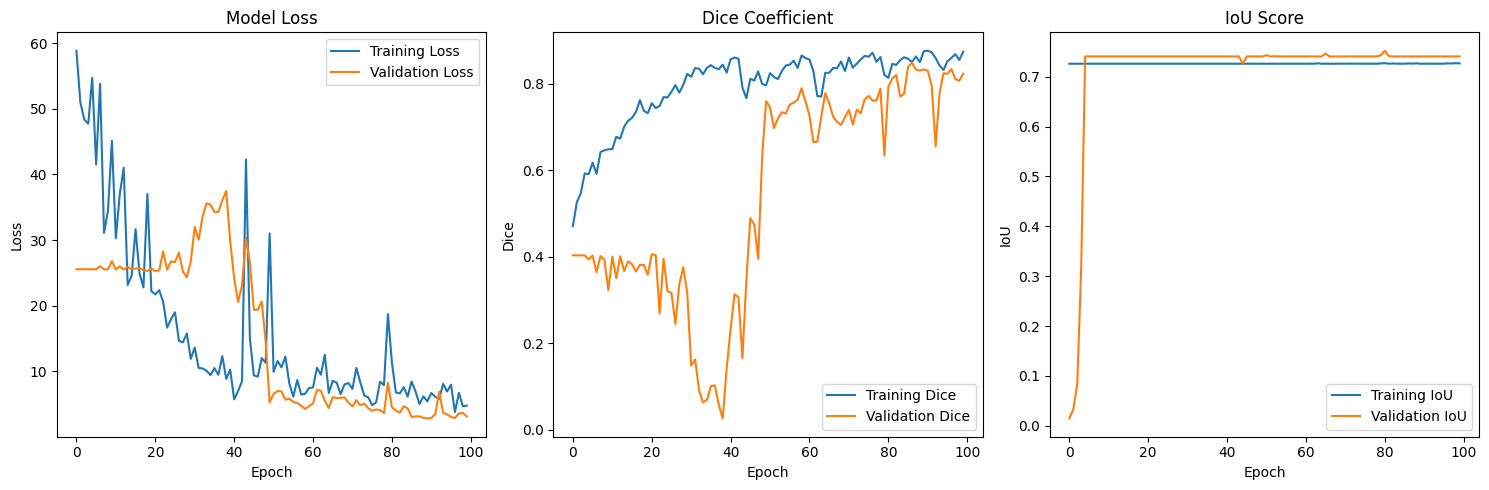

In [14]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history.history['dice_coefficient'], label='Training Dice')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(133)
plt.plot(history.history['io_u'], label='Training IoU')
plt.plot(history.history['val_io_u'], label='Validation IoU')
plt.title('IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


Evaluating on test set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9296 - dice_coefficient: 0.7967 - io_u: 0.7894 - loss: 0.3905
Test Loss: 0.5667
Test Accuracy: 0.9315
Test Dice Coefficient: 0.8056
Test IoU: 0.7842
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


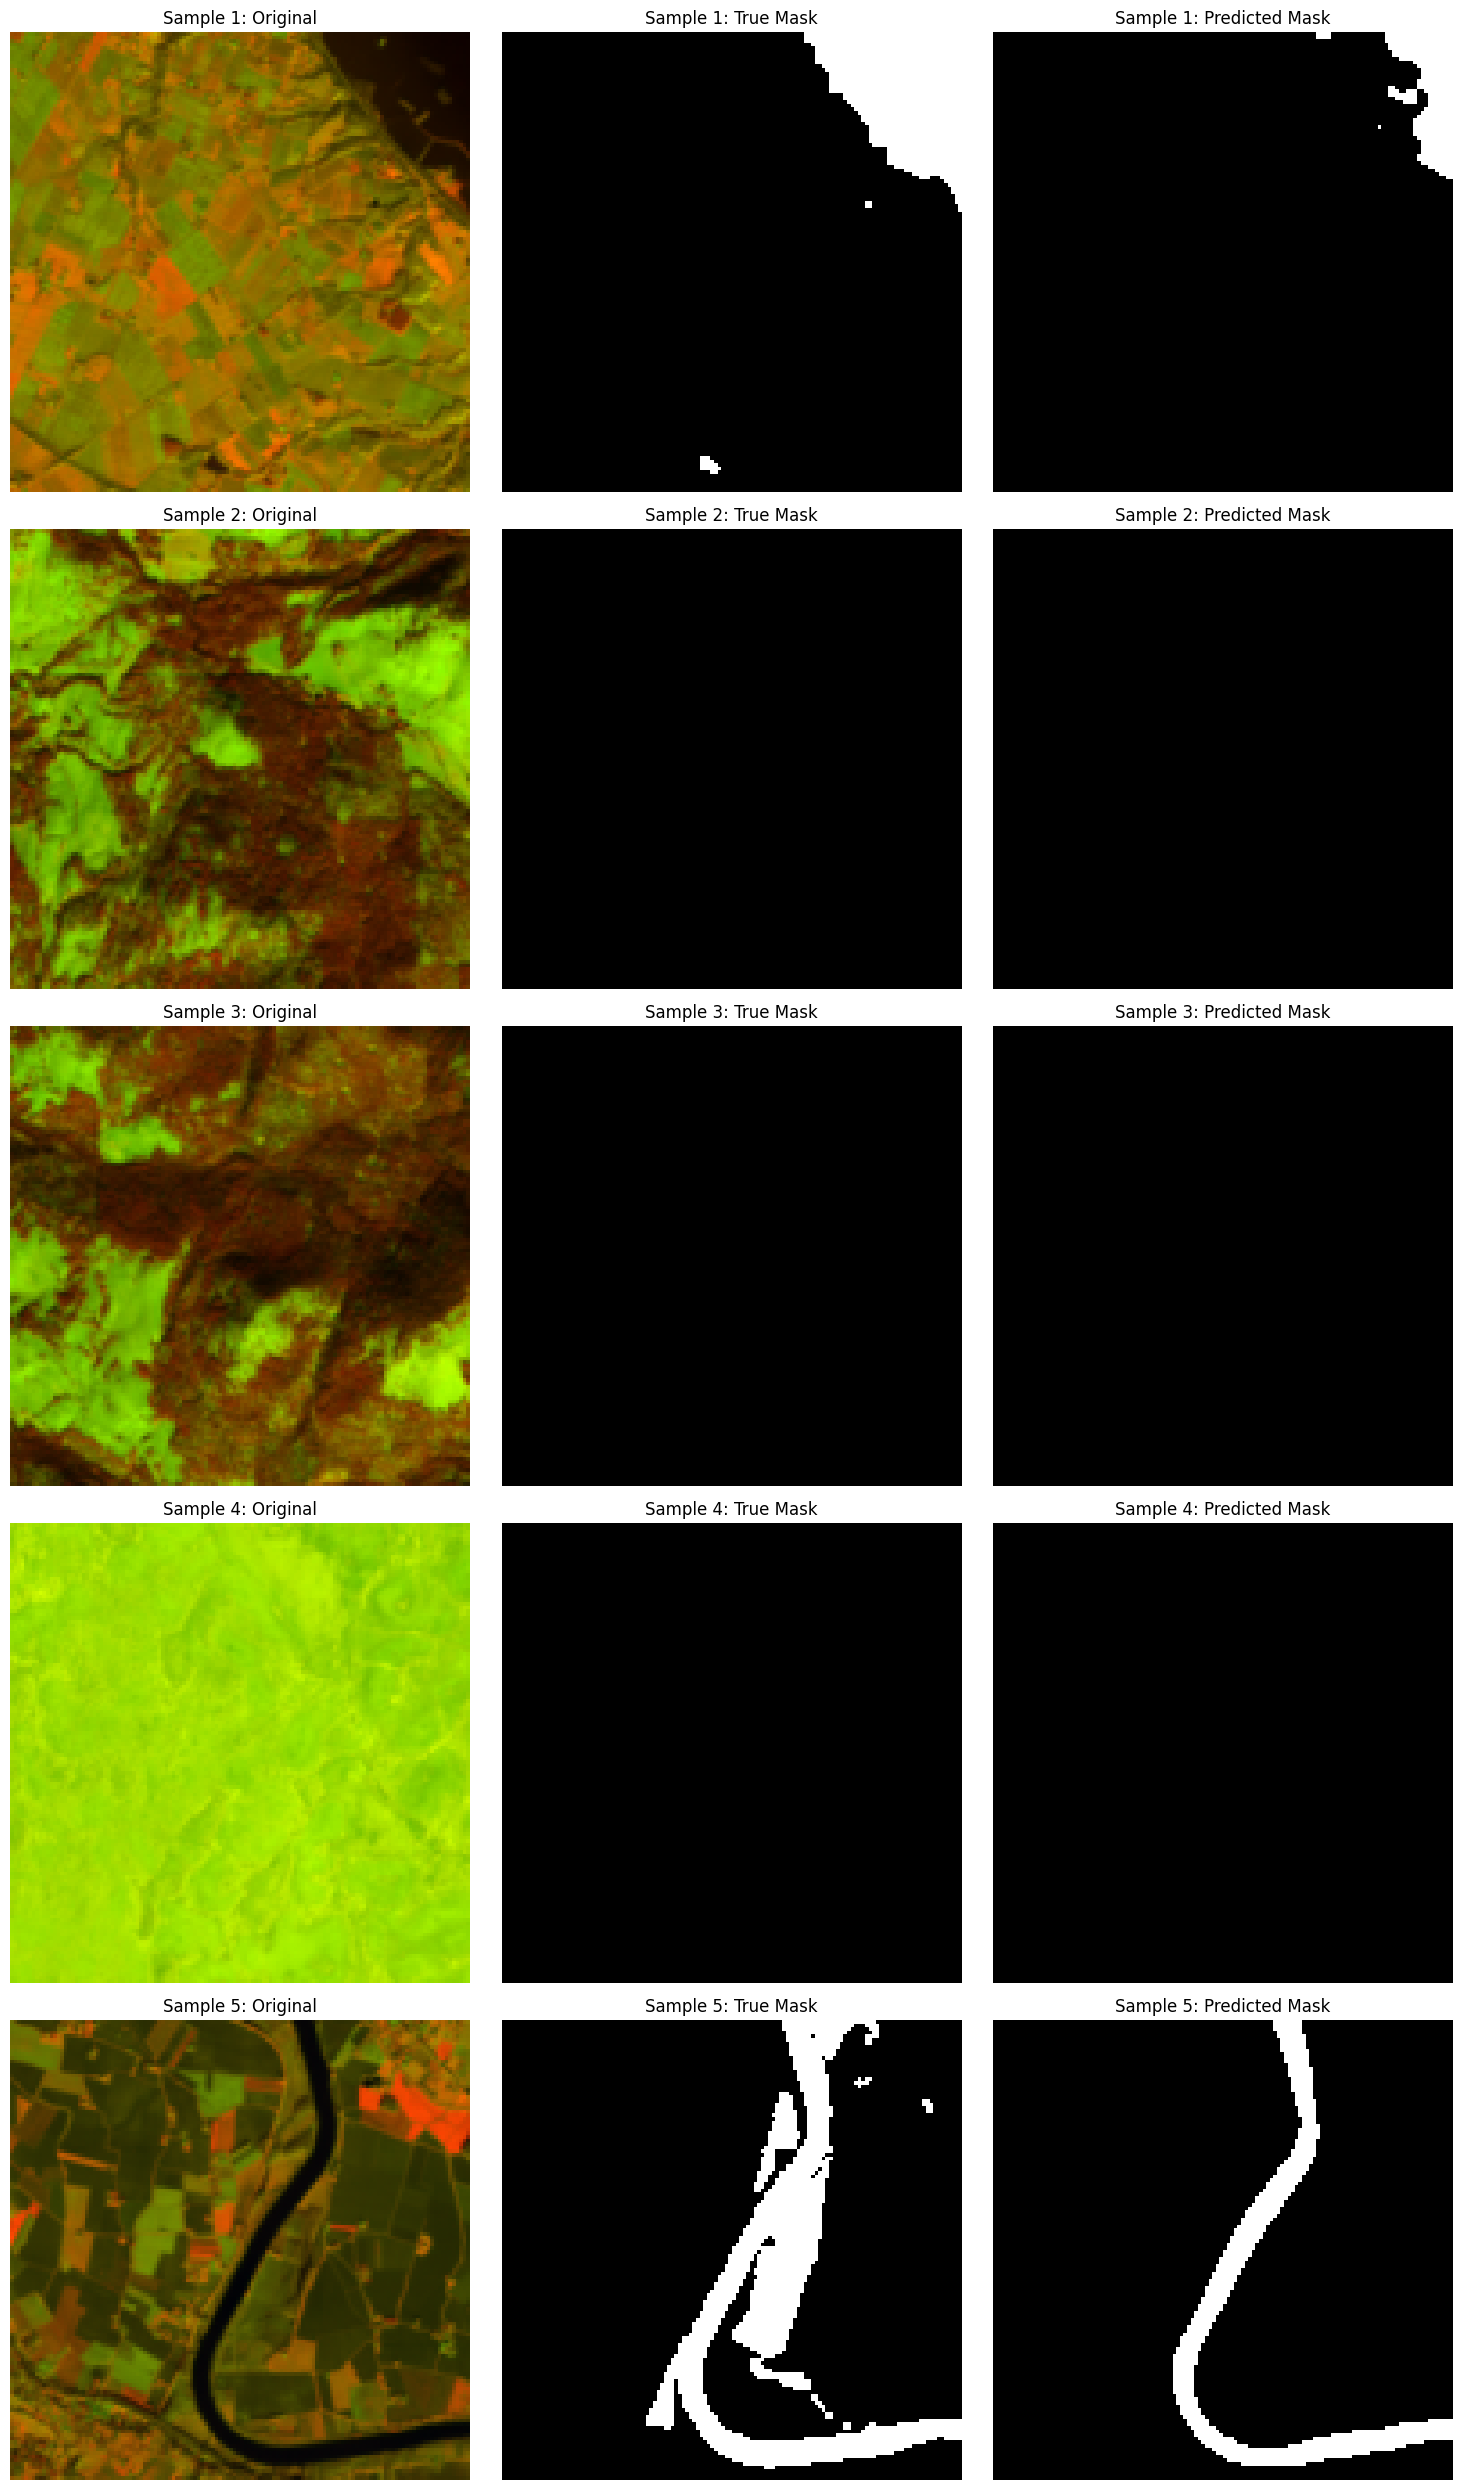

In [16]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_generator = SegmentationDataGenerator(X_test, y_test, batch_size=16, shuffle=False)
test_loss, test_acc, test_dice, test_iou = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")
print(f"Test IoU: {test_iou:.4f}")

# Make predictions
predictions = model.predict(X_test)

# Visualize results
n_samples = 5
plt.figure(figsize=(15, 5*n_samples))

for i in range(n_samples):
    # Original image
    plt.subplot(n_samples, 3, i*3 + 1)
    plt.title(f"Sample {i+1}: Original")
    plt.imshow(X_test[i])
    plt.axis('off')
    
    # True mask
    plt.subplot(n_samples, 3, i*3 + 2)
    plt.title(f"Sample {i+1}: True Mask")
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    
    # Predicted mask
    plt.subplot(n_samples, 3, i*3 + 3)
    plt.title(f"Sample {i+1}: Predicted Mask")
    plt.imshow(predictions[i].squeeze() > 0.5, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
